In [1]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import requests
import re
from config import key

In [37]:
#user input Minnesota city name, string
city = "Brainerd"
#user input 3 digit fish_id, string
species = "NOP"
#user input search distance in miles from city, float
travel = 20
#user input number of results desired
requested_results = 8
#user input YYYY-MM-DD format, datetime64
start_date = np.datetime64("2000-01-31")
#user input gear from gear list, string, optional
gear = "Standard gill nets"

In [3]:
#read .csv files
lakes_data = pd.read_csv("Resources/lake_info/lake_information_clean.csv", converters={"lake_ID": str})
fish_id = pd.read_csv("Resources/fish_id_info/fish_id_list.csv")

In [4]:
# call API to return city geo coordinates
params = {
    "city": city,
    "state": "MN",
    "country": "United States of America",
    "apiKey": key
}
base_url = "https://api.geoapify.com/v1/geocode/search"
response = requests.get(base_url, params=params).json()
lon = response["features"][0]["geometry"]["coordinates"][0]
lat = response["features"][0]["geometry"]["coordinates"][1]

In [56]:
#add methods

#convert coordinate lat or lon from degrees to radians; coordinate = -94.728528
def get_radians(coordinate):
    radian = coordinate*np.pi/180
    return radian

#calculate distance between 2 geographic degree points; lon1 = -94.728528 , lat1 = 44.308025
def get_distance(lat1, lon1, lat2, lon2):
    distance = np.arccos(np.sin(get_radians(lat1))*np.sin(get_radians(lat2)) + \
                         np.cos(get_radians(lat1))*np.cos(get_radians(lat2)) * \
                         np.cos(get_radians(lon2)-get_radians(lon1)))*3958.8
    return distance

#input fish_catch_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64, gear as str
#returns list of cpue column in dataframe for boxplot
def get_cpue_box(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    cpue_boxplot_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["gear"] == gear) & \
                            (df["survey_date"] >= start_date) & \
                            (df["lake_ID"] == lakeid), "CPUE"]
        if species_cpue.empty == False:
            cpue_boxplot_list.append(species_cpue)
    return cpue_boxplot_list

#uses a list format to plot cpue boxplots
def plot_cpue_box(fishlist, lakes):
    plt.boxplot(fishlist)
    labels = lakes
    ticks = range(1, len(lakes)+1)
    plt.xticks(ticks=ticks, labels=labels, rotation=45, ha="right")
    plt.title(species_name)
    plt.show()

#input cpue_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return cpue data for scatterplot using fish data dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_cpue_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_cpue_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["survey_date"] >= start_date) & \
                            (df["gear"] == gear) & \
                            (df["lake_ID"] == lakeid), "CPUE"]
        lake_scatter_cpue_list.append(species_cpue)
    return lake_scatter_cpue_list

#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return avg species length data for scatterplot using fish length dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_avglen_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    lake_scatter_length_list = []
    for lakeid in lakes:
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_ID"] == lakeid), "averageLength"]
        lake_scatter_length_list.append(species_length)
    return lake_scatter_length_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return survey date data for scatterplot using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_survey_date_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_survey_date_list = []
    for lakeid in lakes:
        try:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "survey_date"]
        except KeyError:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "survey_date"]            
        lake_scatter_survey_date_list.append(species_survey_date)
    return lake_scatter_survey_date_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return numeric survey date data for regression line using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_numeric_survey_date_regress(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_numeric_survey_date_list = []
    for lakeid in lakes:
        try:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "numeric_survey_date"]
        except KeyError:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "numeric_survey_date"]            
        lake_scatter_numeric_survey_date_list.append(lake_scatter_numeric_survey_date)
    return lake_scatter_numeric_survey_date_list

#input fish= length or cpue series int, sdate= survey date series datetime64, lakes= [list of lake id], ytext= ylabel value
#scatter plot average lengths per lake
def plot_scatter(fish, sdate, lakes, ytext=""):
    for _ in range(len(lakes)):
        plt.scatter(sdate[_],fish[_], label=cpue_results[_])
    plt.title(f"{ytext} measurements for {species_name}")
    plt.ylabel(f"{species_name} {ytext}")
    plt.xlabel("Date")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc="best")
    plt.show()
    
#plot regression lines with scatter plots for each lake
def plot_regression_scatter(fish, sdate, ndate, lakes, ytext=""):
    print("Notes:")
    for lake in range(len(lakes)):
        if len(ndate[lake]) == 0:
            print(f"Survey Data Empty for {lakes[lake]}")
        elif len(ndate[lake]) == 1:
            print(f"Only 1 data point exists for {lakes[lake]}")
        else:
            regression_values = linregress(ndate[lake],fish[lake])
            fig, ax1 = plt.subplots(1,1)
            fig.suptitle(f"{ytext} trend for {cpue_results[lake]}")
            ax1.scatter(sdate[lake],fish[lake], label=cpue_results[lake])
            ax1.set_ylabel(f"{species_name} {ytext}")
            ax1.set_xlabel(f"R2 value = {regression_values.rvalue}")
            plt.xticks(rotation=45)
            ax2 = ax1.twiny()
            ax2.plot(ndate[lake],(regression_values.slope*ndate[lake] + regression_values.intercept))
    plt.show()

In [6]:
#get list of lakes within travel distance 
closeby = lakes_data.loc[(get_distance(lat, lon, lakes_data["Latitude"], lakes_data["Longitude"]) < travel)]
closeby

,lake_ID,Lake Name,Lake County,Nearest Town,Lake Area,Littoral Area,Lake Depth,Mean Depth,Water Access Sites,Longitude,Latitude
14,01020600,Birch,Aitkin,White Hawk,0.00,0.0,0.0,0.0,[],-93.808077,46.369579
107,01020400,Round,Aitkin,Garrison,736.66,322.0,125.0,0.0,['was02224'],-93.803846,46.333776
116,01015600,Spectacle,Aitkin,White Hawk,0.00,0.0,0.0,0.0,[],-93.789552,46.380926
122,01020800,Sunset,Aitkin,Aitkin,221.18,210.0,43.0,0.0,[],-93.809959,46.436060
125,18000200,Long / Tame Fish,Crow Wing,Deerwood (Crow Wing),127.11,52.0,58.0,0.0,[],-93.818833,46.405146
...,...,...,...,...,...,...,...,...,...,...,...
5217,18032003,Gilbert (South Bay),Crow Wing,NaN,0.00,0.0,0.0,0.0,['was01597'],-94.193559,46.379769
5218,18038701,Upper Whipple,Crow Wing,NaN,0.00,0.0,0.0,0.0,['was02225'],-94.310205,46.370487
5219,18038703,Lower Whipple,Crow Wing,NaN,0.00,0.0,0.0,0.0,['was02225'],-94.318689,46.351776
5379,18009301,Rabbit (East Portion),Crow Wing,Cuyuna,669.61,242.0,337.0,0.0,['was00356'],-93.911767,46.530471


In [7]:
lakes = list(closeby["lake_ID"])
lakes

['01020600',
 '01020400',
 '01015600',
 '01020800',
 '18000200',
 '01020700',
 '11021600',
 '11021500',
 '11062400',
 '11021400',
 '11032900',
 '11021300',
 '11033000',
 '11030500',
 '11020900',
 '11032200',
 '49008000',
 '11032300',
 '11031800',
 '11032800',
 '11022600',
 '11021900',
 '11022200',
 '18040800',
 '11041900',
 '11020700',
 '11032000',
 '11022000',
 '11032100',
 '11032400',
 '18039800',
 '11021100',
 '11032600',
 '18040400',
 '11030400',
 '49003600',
 '11021800',
 '18006000',
 '18006500',
 '18003000',
 '18025600',
 '18030600',
 '18038400',
 '18040200',
 '18002600',
 '18003400',
 '18005900',
 '18014000',
 '18011700',
 '18025900',
 '18002000',
 '18007700',
 '18010800',
 '18001800',
 '18030700',
 '18008300',
 '18039500',
 '18006100',
 '18009500',
 '18037400',
 '18036400',
 '18003800',
 '18013100',
 '18012700',
 '18004100',
 '18015500',
 '18034100',
 '18010700',
 '18005800',
 '18031400',
 '18009900',
 '18025700',
 '18040700',
 '18039600',
 '18030500',
 '18000900',
 '18024000',

In [8]:
#JSON response for MN lake id number.
def get_catch_info(lake_id):
    response = requests.get("https://maps2.dnr.state.mn.us/cgi-bin/lakefinder/detail.cgi?type=lake_survey&id="+lake_id)
    return response.json()

def get_fish_catch_summary_data(catch_info):
    fish_catch_list = []
    for i in range(len(catch_info["result"]["surveys"])): 
        survey_date = catch_info["result"]["surveys"][i]["surveyDate"]
        survey_id = catch_info["result"]["surveys"][i]["surveyID"]
        for j in range(len(catch_info["result"]["surveys"][i]["fishCatchSummaries"])):
            fish_catch_summary = catch_info["result"]["surveys"][i]["fishCatchSummaries"][j]
            fish_catch_summary["lake_ID"] = catch_info["result"]["DOWNumber"]
            fish_catch_summary["survey_date"] = survey_date
            fish_catch_summary["survey_ID"] = survey_id
            fish_catch_list.append(fish_catch_summary)
    return fish_catch_list

In [9]:
#retrieve catch survey data from API for all lakes within radius that have survey
fish_catch_data = [get_catch_info(x) for x in lakes if get_catch_info(x)["status"] == "SUCCESS"]

In [38]:
#alter API data return so it can be used in pandas dataframe
catch_list = []
fish_catch_data_clean = get_fish_catch_summary_data(fish_catch_data[0])
for _ in range(len(fish_catch_data)):
    catch = get_fish_catch_summary_data(fish_catch_data[_])
    for _ in range(len(catch)):
        sample = catch[_]
        catch_list.append(sample)

In [39]:
fish_catch_df = pd.DataFrame(catch_list)

In [40]:
#sort and format year survey data then convert to datetime
def survey_date_cleaner(dfseries):
    dfseries = dfseries.copy()
    for _ in range(len(dfseries)):
        dfseries[_] = dfseries[_].replace("/","-")
        if matches := re.search(r"^(\d?\d{1})-(\d?\d{1})-(\d{4})$", dfseries[_], re.IGNORECASE):
            dfseries[_] = f"{matches.group(3)}-{matches.group(2)}-{matches.group(1)}"
        try:
            dfseries[_] = pd.to_datetime(dfseries[_],format="%Y-%m-%d")
        except ValueError:
            if matches := re.search(r"^(\d{4})-(\d?\d{1})-(\d?\d{1})$", dfseries[_], re.IGNORECASE):
                dfseries[_] = f"{matches.group(1)}-{matches.group(3)}-{matches.group(2)}"
            dfseries[_] = pd.to_datetime(dfseries[_],format="%Y-%m-%d")
    dfseries = pd.to_datetime(dfseries,format="%Y-%m-%d")
    return dfseries

#input CPUE column data series
#drop strings from cpue data series and convert to int(found some "? marks")
def cpue_cleaner(dfseries):
    i=0
    for _ in dfseries:
        try:
            np.float64(_)
            i = i + 1
        except ValueError:
            print(i, _,"valueerror")
            dfseries = dfseries.drop([i])
            i = i + 1
    dfseries = pd.to_numeric(dfseries)
    return dfseries

#input quartile data series
#split lower quartile and convert to float
def lower_quartile_cleaner(dseries):
    quartile_list = []
    for quartile in dseries:
        try:
            if len(quartile.split("-")) == 2:
                try:
                    quartile_list.append(float(quartile.split("-")[0]))
                except ValueError:
                    quartile_list.append(float("nan"))
                    pass
            else:
                quartile_list.append(float("nan"))
        except AttributeError:
            quartile_list.append(quartile)
            pass
    return quartile_list

#input quartile data series
#split upper quartile and convert to float
def upper_quartile_cleaner(dseries):
    quartile_list = []
    for quartile in dseries:
        try:
            if len(quartile.split("-")) == 2:
                try:
                    quartile_list.append(float(quartile.split("-")[1]))
                except ValueError:
                    quartile_list.append(float("nan"))
                    pass
            else:
                quartile_list.append(float("nan"))
        except AttributeError:
            quartile_list.append(quartile)
            pass
    return quartile_list

In [41]:
#clean incomming API data
fish_catch_df["CPUE"] = cpue_cleaner(fish_catch_df["CPUE"])
fish_catch_df["survey_date"] = survey_date_cleaner(fish_catch_df["survey_date"])
fish_catch_df["count_lower_quartile"] = lower_quartile_cleaner(fish_catch_df["quartileCount"])
fish_catch_df["count_upper_quartile"] = upper_quartile_cleaner(fish_catch_df["quartileCount"])
fish_catch_df["weight_lower_quartile"] = lower_quartile_cleaner(fish_catch_df["quartileWeight"])
fish_catch_df["weight_upper_quartile"] = upper_quartile_cleaner(fish_catch_df["quartileWeight"])
fish_catch_df["gearCount"] = fish_catch_df["gearCount"].astype("int")
fish_catch_df = fish_catch_df.drop(columns=["quartileCount", "quartileWeight"])
fish_catch_df = fish_catch_df.sort_values("survey_date")

622 ? valueerror
2314 ∞ valueerror
7077 ∞ valueerror
7079 ∞ valueerror
7088 ∞ valueerror
7092 ∞ valueerror
7098 ∞ valueerror
7110 ∞ valueerror
7113 ∞ valueerror
7114 ∞ valueerror
11236 ∞ valueerror
15202 ? valueerror
15226 ? valueerror
15403 ∞ valueerror
15434 ∞ valueerror


In [42]:
#add numeric survey date column as an integer to fish CPUE
fish_catch_df["survey_date"] = pd.to_datetime(fish_catch_df["survey_date"],format="%Y-%m-%d")
fish_catch_df["numeric_survey_date"] = pd.to_numeric(fish_catch_df["survey_date"])
fish_catch_df = fish_catch_df.sort_values("survey_date")
fish_catch_df = fish_catch_df.reset_index(drop=True)

In [43]:
median_catch = fish_catch_df.loc[(fish_catch_df["species"] == species) & (fish_catch_df["survey_date"] >= start_date)]
median_catch = median_catch["lake_ID"].value_counts().loc[median_catch["lake_ID"].value_counts() >= median_catch["lake_ID"].value_counts().median()]
median_catch = list(median_catch.index)
median_catch

['49001600',
 '11030500',
 '18030800',
 '18038600',
 '49013100',
 '18024300',
 '49007900',
 '18038700',
 '18011700',
 '18025100',
 '18037300',
 '11022200',
 '18037900',
 '18037100',
 '18009000',
 '01020400',
 '11021800',
 '49001900',
 '18015500',
 '18003400',
 '18030500',
 '18013600',
 '18009301',
 '18009600',
 '18024200',
 '18037500',
 '11030400',
 '18037200',
 '18039900',
 '18014500',
 '18002000',
 '18033800',
 '18008800',
 '18036400',
 '18037600',
 '18035200',
 '18009302',
 '18003800',
 '18040300',
 '18010400',
 '18040900',
 '18037700',
 '18032000',
 '18001800',
 '11022000']

In [44]:
median_cpue = fish_catch_df.loc[(fish_catch_df["species"] == species) & \
                                (fish_catch_df["survey_date"] >= start_date) & \
                                (fish_catch_df["lake_ID"].isin(median_catch)) & \
                                (fish_catch_df["gear"] == gear)]
median_cpue = median_cpue.groupby("lake_ID").median() ["CPUE"]
median_cpue = median_cpue.sort_values(ascending=False)
median_cpue

lake_ID
18033800    18.220
18003400    16.600
18024300    15.710
18024200    12.365
18037600    11.775
18040900    11.540
18039900    11.500
18036400    11.115
18038700    10.875
18037100    10.500
18025100     9.545
18011700     9.335
18008800     8.830
11022200     8.665
01020400     8.560
11030400     8.250
18032000     8.225
18030500     7.700
18037200     7.600
18035200     7.580
18013600     7.500
11022000     7.330
18037900     7.000
49001900     6.830
18010400     6.710
18009000     6.670
18037700     6.500
11021800     6.220
18009302     5.710
18002000     5.705
18009301     5.190
18001800     5.110
18038600     5.000
49001600     4.960
18009600     4.540
18040300     4.440
18003800     4.375
18037500     4.330
18037300     4.200
49013100     4.125
11030500     4.070
18014500     3.945
18030800     3.670
49007900     3.000
18015500     2.835
Name: CPUE, dtype: float64

In [45]:
cpue_results = median_cpue.index[0:requested_results]
cpue_results = list(cpue_results)
cpue_results

['18033800',
 '18003400',
 '18024300',
 '18024200',
 '18037600',
 '18040900',
 '18039900',
 '18036400']

In [46]:
#gather CPUE data for target fish species
cpue_data = fish_catch_df.loc[(fish_catch_df["species"] == species) & \
                              (fish_catch_df["survey_date"] >= start_date) & \
                              (fish_catch_df["gear"] == gear)]
cpue_data = cpue_data.groupby(["lake_ID", "species"]).median() ["CPUE"]
species_name = fish_id.loc[fish_id["fish_id"] == species, "fish_description"].values[0]
species

'NOP'

In [47]:
#filter and prepare a CPUE list for box plots
cpue_list = get_cpue_box(fish_catch_df, cpue_results, species, start_date)

In [48]:
cpue_list

[9671     14.67
 11684    18.22
 14868    18.56
 Name: CPUE, dtype: float64,
 8573     16.60
 10319    17.40
 11474    12.93
 12627    19.60
 16390     9.87
 Name: CPUE, dtype: float64,
 9150     12.50
 9777     15.25
 12562    17.00
 17180    16.17
 Name: CPUE, dtype: float64,
 9211      6.00
 9797     10.00
 12658    14.73
 17218    15.83
 Name: CPUE, dtype: float64,
 8880     11.11
 10764    12.44
 13494     8.56
 16587    13.11
 Name: CPUE, dtype: float64,
 10395    13.75
 14412     9.33
 Name: CPUE, dtype: float64,
 7986     11.6
 11880    11.5
 15198    11.5
 Name: CPUE, dtype: float64,
 7920     12.40
 9243     15.00
 14106     8.50
 17359     9.83
 Name: CPUE, dtype: float64]

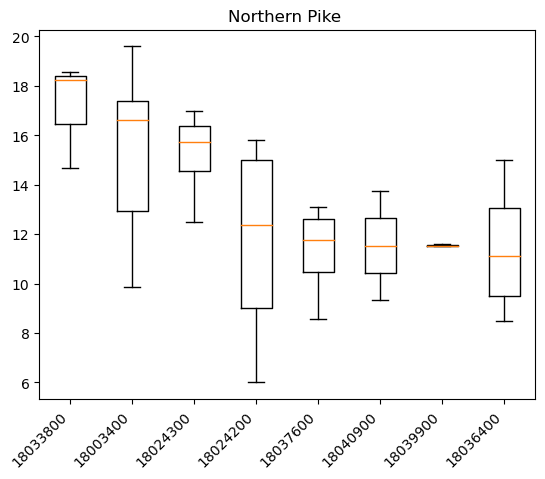

In [49]:
#plot boxplot of CPUE per lake
cpue_list_length = len(cpue_list)
plot_cpue_box(cpue_list, cpue_results[:cpue_list_length])

In [50]:
#create fish CPUE data series for scatter plot and regression line
fish_cpue = get_cpue_scatter(fish_catch_df, cpue_results, species, start_date)
fish_cpue

[9671     14.67
 11684    18.22
 14868    18.56
 Name: CPUE, dtype: float64,
 8573     16.60
 10319    17.40
 11474    12.93
 12627    19.60
 16390     9.87
 Name: CPUE, dtype: float64,
 9150     12.50
 9777     15.25
 12562    17.00
 17180    16.17
 Name: CPUE, dtype: float64,
 9211      6.00
 9797     10.00
 12658    14.73
 17218    15.83
 Name: CPUE, dtype: float64,
 8880     11.11
 10764    12.44
 13494     8.56
 16587    13.11
 Name: CPUE, dtype: float64,
 10395    13.75
 14412     9.33
 Name: CPUE, dtype: float64,
 7986     11.6
 11880    11.5
 15198    11.5
 Name: CPUE, dtype: float64,
 7920     12.40
 9243     15.00
 14106     8.50
 17359     9.83
 Name: CPUE, dtype: float64]

In [51]:
#create date series for cpue scatter plots and regression lines
cpue_sdate = get_survey_date_scatter(fish_catch_df, cpue_results, species, start_date)
cpue_ndate = get_numeric_survey_date_regress(fish_catch_df, cpue_results, species, start_date)

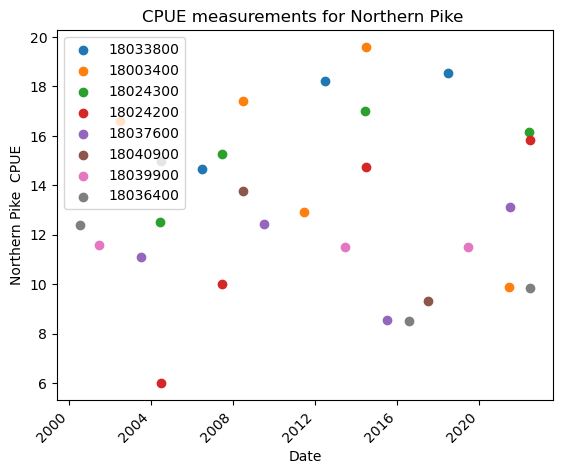

In [52]:
#plot scatter of CPUE per lake
plot_scatter(fish_cpue, cpue_sdate, cpue_results, ytext="CPUE")

Notes:


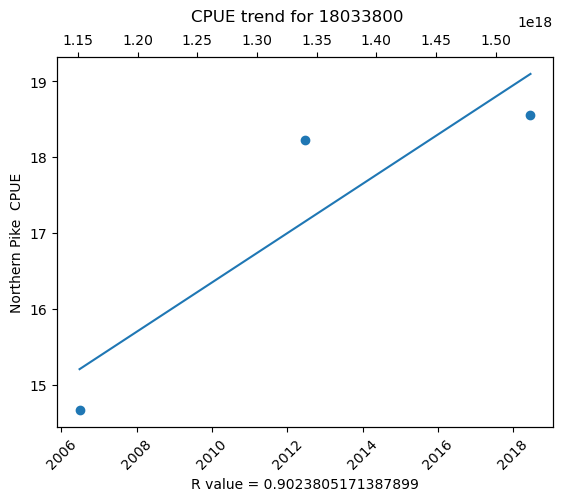

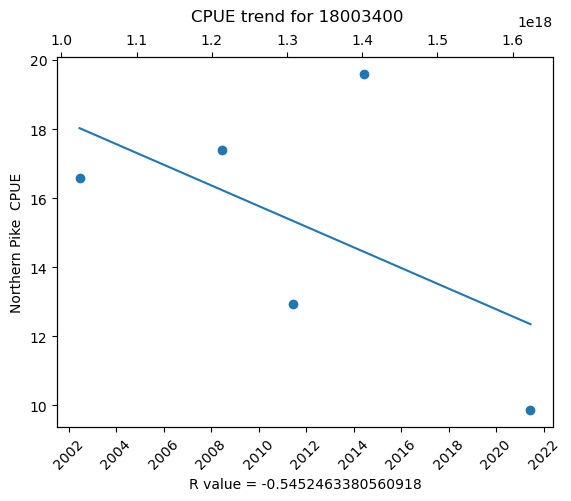

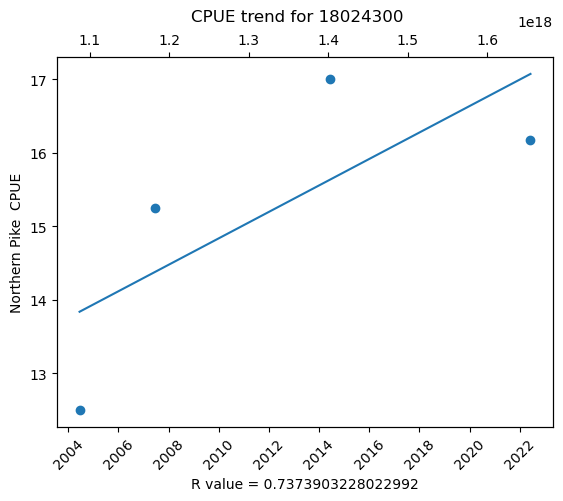

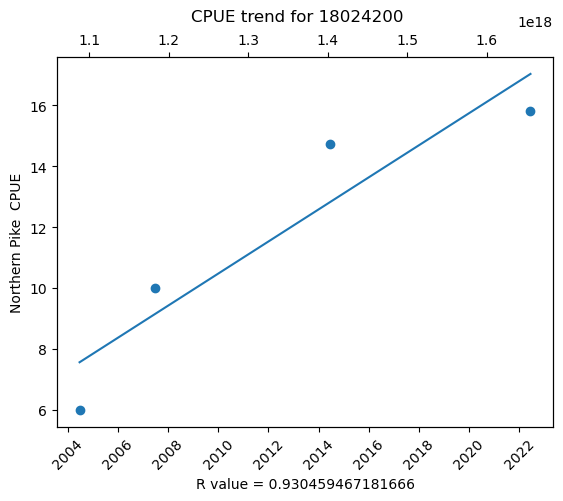

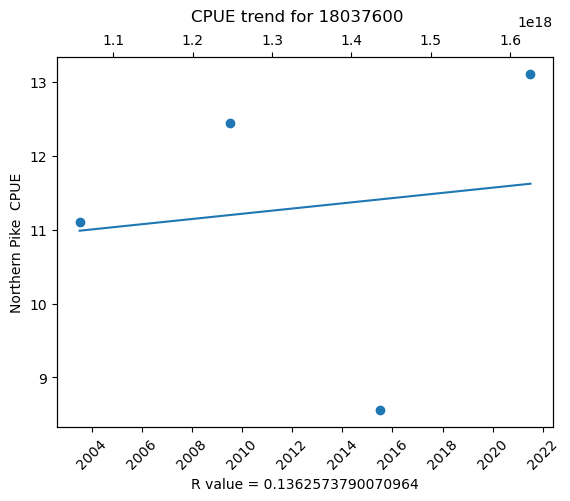

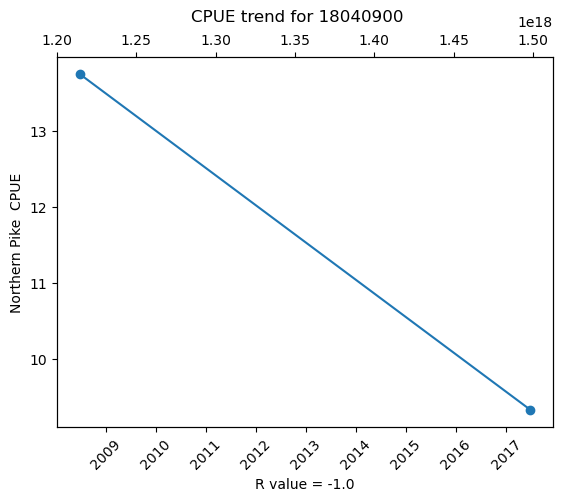

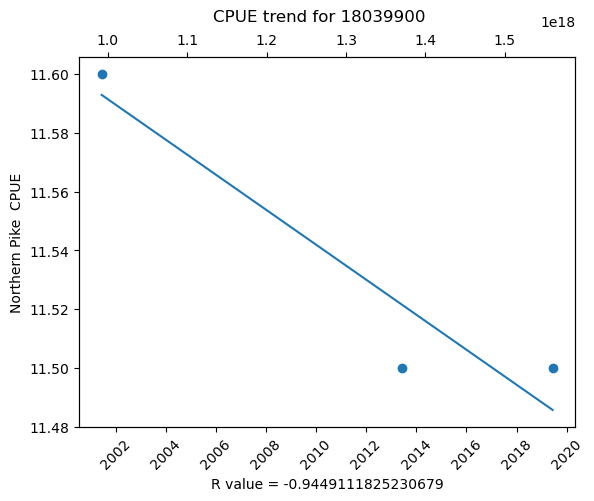

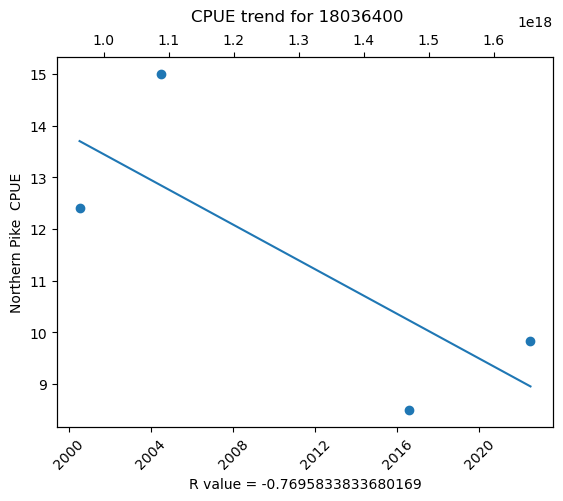

In [57]:
#plot regression lines for each lake CPUE over time
plot_regression_scatter(fish_cpue, cpue_sdate, cpue_ndate, cpue_results, "CPUE")

In [163]:
#fish length summary returns a list of dictionaries lengths and counts by species by survey ID
def get_fish_length_summary_data(lake_info):
    fish_length_list = []
    for i in range(len(lake_info["result"]["surveys"])): 
        survey_date = lake_info["result"]["surveys"][i]["surveyDate"]
        survey_id = lake_info["result"]["surveys"][i]["surveyID"]
        for j in lake_info["result"]["surveys"][i]["lengths"].keys():
            fish_length_summary = {}
            fish_length_summary["lake_ID"] = lake_info["result"]["DOWNumber"]
            fish_length_summary["species"] = j
            fish_length_summary["fish_count"] = lake_info["result"]["surveys"][i]["lengths"][j]["fishCount"]
            fish_length_summary["maximum_length"] = lake_info["result"]["surveys"][i]["lengths"][j]["maximum_length"]
            fish_length_summary["minimum_length"] = lake_info["result"]["surveys"][i]["lengths"][j]["minimum_length"]
            fish_length_summary["survey_date"] = survey_date
            fish_length_summary["survey_ID"] = survey_id
            fish_length_list.append(fish_length_summary)
    return fish_length_list

In [164]:
#input string data series with rows of "[1,1,2,2,2,3,4,7,7,7]"
#returns fish_count series column as a list of float averages e.g. [5.1, 4.6, 8.8]
def fish_length_averager(dfseries):
    fish_length_averages = []
    for row in dfseries:
        fish_length_averages.append(np.mean(row))
    return fish_length_averages

In [165]:
#input fish_count column data series
#returns fish_count column in dataframe as a list of individual integer measurements e.g. [0,0,1,1,1,2,3,3,4]
def fish_length_cleaner(dfseries):
    fish_lengths = []
    #scrub each row string and convert to list of lengths sampled
    for row in dfseries:
        sample_lengths = []
        for n in range(len(row)):
            for i in range(row[n][1]):
                sample_lengths.append(row[n][0])
        fish_lengths.append(sample_lengths)
    return fish_lengths

In [166]:
#alter API data return so it can be used in pandas dataframe for lengths
length_list = []
fish_length_data_clean = get_fish_length_summary_data(fish_catch_data[0])
for _ in range(len(fish_catch_data)):
    catch = get_fish_length_summary_data(fish_catch_data[_])
    for _ in range(len(catch)):
        sample = catch[_]
        length_list.append(sample)

In [167]:
fish_length_df = pd.DataFrame(length_list)
fish_length_df.head()

,lake_ID,species,fish_count,maximum_length,minimum_length,survey_date,survey_ID
0,01020400,YEB,"[[10, 1], [11, 3], [13, 1], [8, 1], [9, 1]]",13,8,2013-08-19,5131321739753010
1,01020400,HSF,"[[3, 6], [4, 5], [5, 6], [6, 11], [7, 6], [8, 1]]",8,3,2013-08-19,5131321739753010
2,01020400,NOP,"[[12, 1], [14, 1], [15, 3], [16, 5], [17, 6], ...",32,12,2013-08-19,5131321739753010
3,01020400,BLG,"[[3, 66], [4, 87], [5, 61], [6, 25], [7, 8], [...",8,3,2013-08-19,5131321739753010
4,01020400,CAP,"[[30, 1]]",30,30,2013-08-19,5131321739753010


In [168]:
#clean length data
fish_length_df["survey_date"] = survey_date_cleaner(fish_length_df["survey_date"])
fish_length_df["fish_count"] = fish_length_cleaner(fish_length_df["fish_count"])
fish_length_df["averageLength"] = fish_length_averager(fish_length_df["fish_count"])
fish_length_df = fish_length_df.sort_values("survey_date")
fish_length_df.head()

,lake_ID,species,fish_count,maximum_length,minimum_length,survey_date,survey_ID,averageLength
3807,18006900,GSF,"[3, 4]",4,3,1993-06-14,114270,3.500000
4542,18013500,YEP,"[5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, ...",8,5,1993-06-14,114357,6.294118
4541,18013500,BLC,"[6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8]",8,6,1993-06-14,114357,7.272727
4540,18013500,RKB,"[6, 6, 7, 7, 7, 7, 8]",8,6,1993-06-14,114357,6.857143
3815,18006900,YEB,"[10, 11, 11, 11, 7, 7, 8, 8, 8, 9, 9, 9]",11,7,1993-06-14,114270,9.000000


In [169]:
#add numeric survey date column as an integer to fish length
fish_length_df["survey_date"] = pd.to_datetime(fish_length_df["survey_date"],format="%Y-%m-%d")
fish_length_df["numeric_survey_date"] = pd.to_numeric(fish_length_df["survey_date"])
fish_length_df = fish_length_df.sort_values("survey_date")
fish_length_df = fish_length_df.reset_index(drop=True)

In [170]:
fish_length_df.head()

,lake_ID,species,fish_count,maximum_length,minimum_length,survey_date,survey_ID,averageLength,numeric_survey_date
0,18006900,GSF,"[3, 4]",4,3,1993-06-14,114270,3.500000,740016000000000000
1,18013500,BRB,"[10, 11, 12, 13, 13]",13,10,1993-06-14,114357,11.800000,740016000000000000
2,18013500,BLG,"[1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, ...",8,1,1993-06-14,114357,5.051546,740016000000000000
3,18006900,TLC,"[11, 11, 12, 12, 12, 12, 13, 15, 15, 15, 17, 1...",19,11,1993-06-14,114270,15.608696,740016000000000000
4,18013500,NOP,"[10, 11, 12, 13, 13, 13, 14, 15, 15, 15, 15, 1...",30,10,1993-06-14,114357,18.117647,740016000000000000


In [171]:
#create date series for length scatter plots and regression lines
length_sdate = get_survey_date_scatter(fish_length_df, cpue_results, species, start_date)
length_ndate = get_numeric_survey_date_regress(fish_length_df, cpue_results, species, start_date)

In [172]:
#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#returns dictionary of fish_count column in dataframe for histogram, format {lake ID:[0,0,1,2,2,2,2,3,3]}
def get_length_hist(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    fishdict = {}
    for lakeid in lakes:
        #sort by lake and species
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_ID"] == lakeid), "fish_count"]        
        fish_list = []
        for _ in species_length.values:
            fish_list = _ + fish_list
        fishdict[lakeid] = fish_list
    return fishdict

#Uses a dictionary format {lake ID:[0,0,1,2,2,2,2,3,3]} to plot fish length histograms
def plot_length_hist(fishdict):
    i = -1
    for lakeid in fishdict.keys():
        i += 1
        if bool(fishdict[lakeid]) == False:
            print(f"{lakeid} did not return results for the timeframe or species specified.")
        else:
            plt.hist(fishdict[lakeid])
            plt.xlabel("Size in Inches")
            plt.ylabel("Number sampled")
            plt.title(f"{cpue_results[i]} lengths for {species_name}")
            plt.show()

In [173]:
#filter and prepare a list of lengths for histogram plots
lengthdict = get_length_hist(fish_length_df, cpue_results, species, start_date)

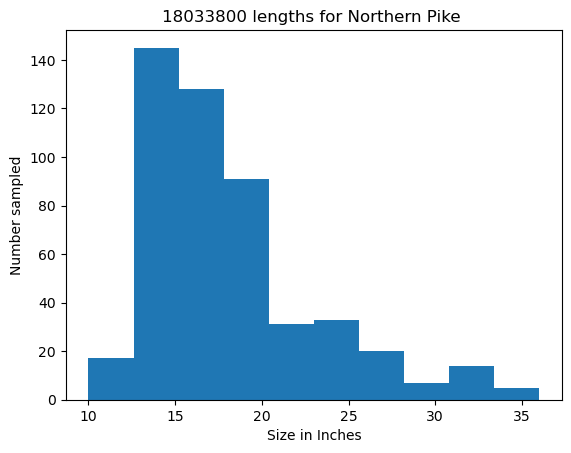

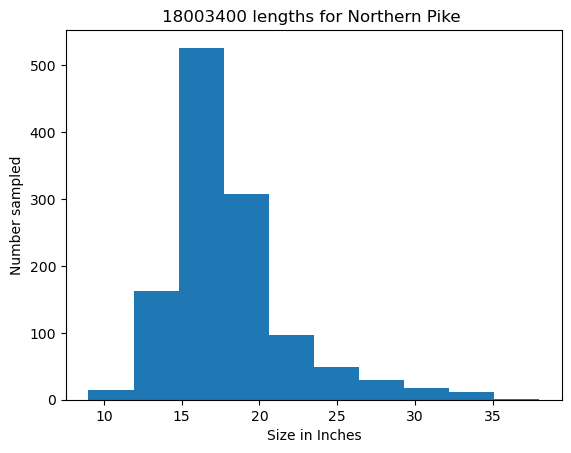

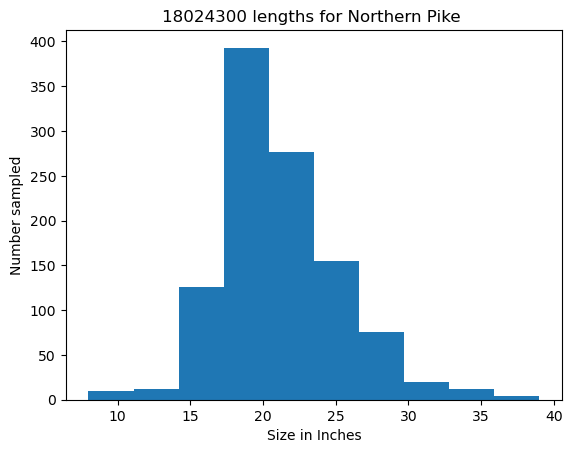

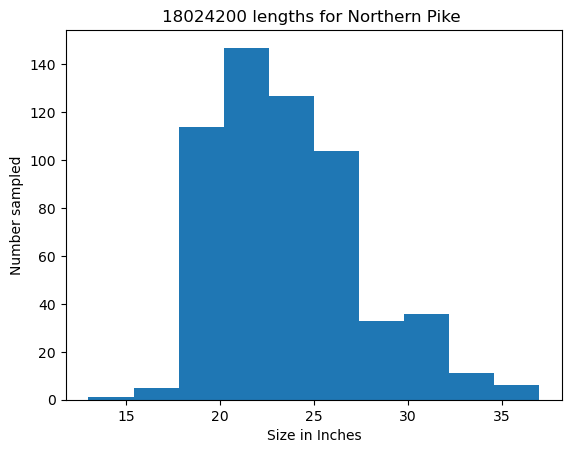

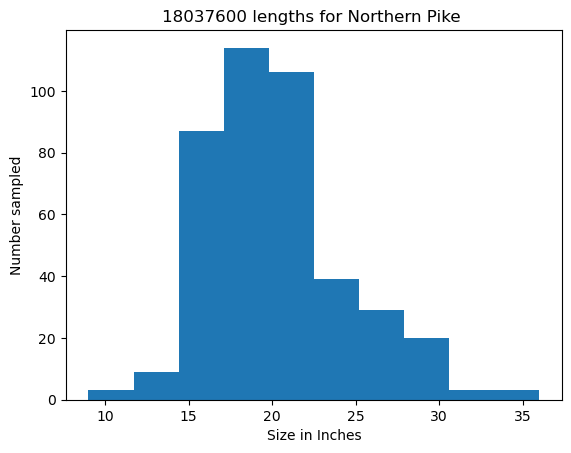

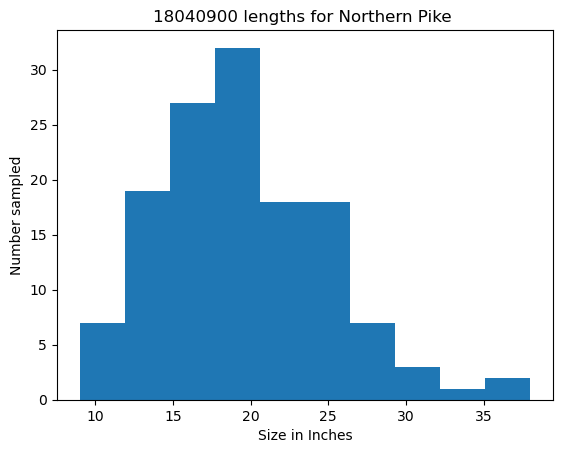

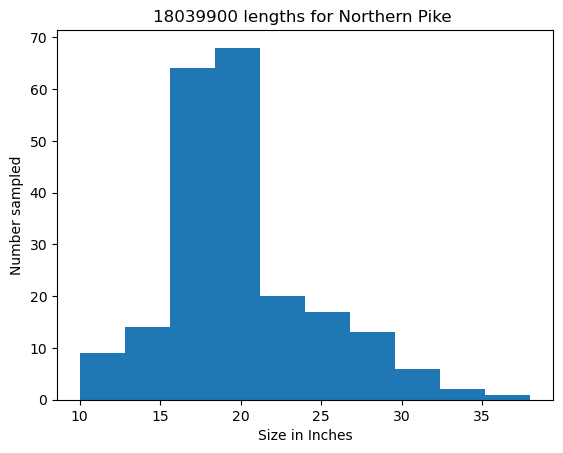

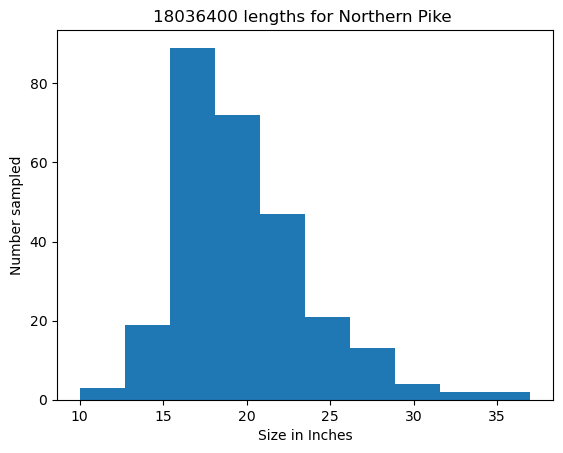

In [174]:
#plot histograms of lengths per lake
plot_length_hist(lengthdict)

In [175]:
#create fish length data series for scatter plot and regression line
fishavglength = get_avglen_scatter(fish_length_df, cpue_results, species, start_date)

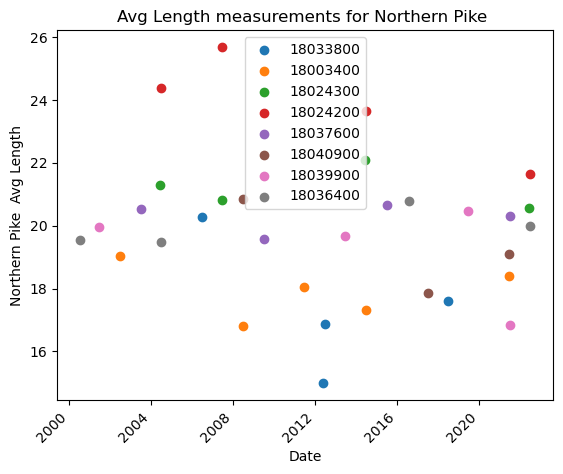

In [177]:
#plot scatter of average fish lengths per lake
plot_scatter(fishavglength, length_sdate, cpue_results, "Avg Length")

Notes:


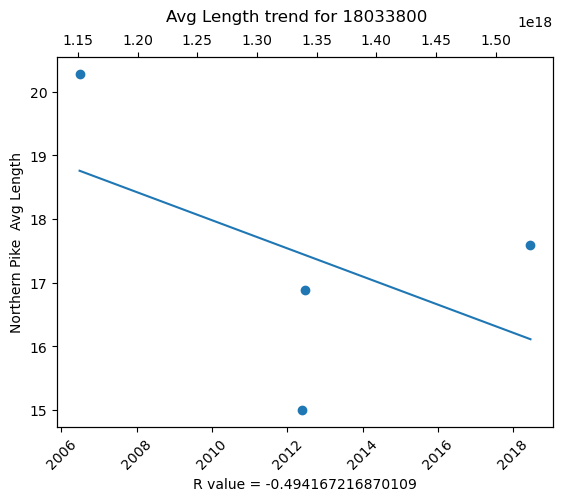

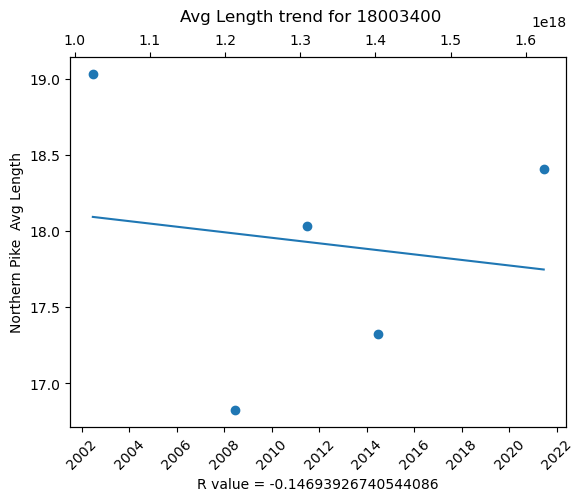

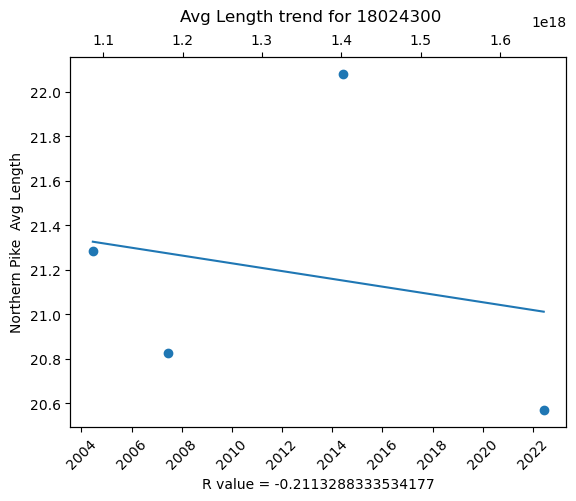

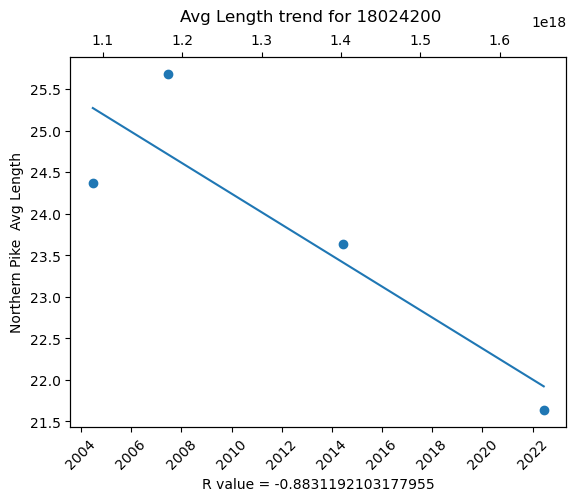

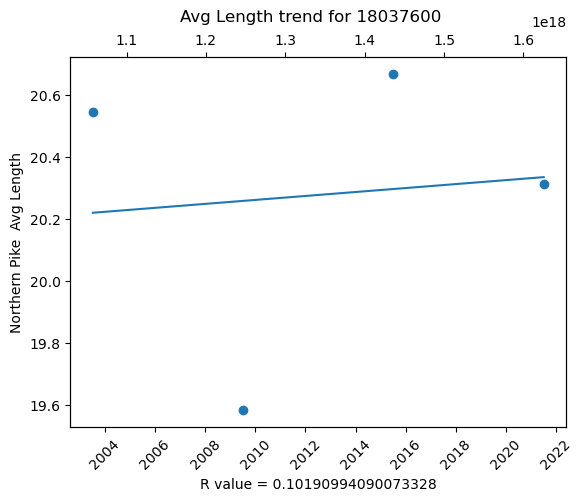

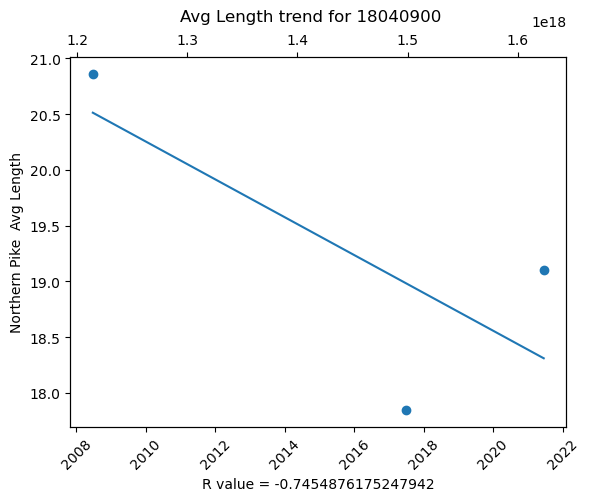

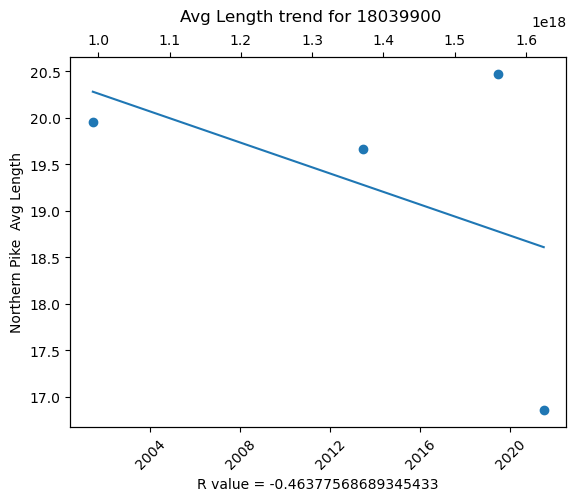

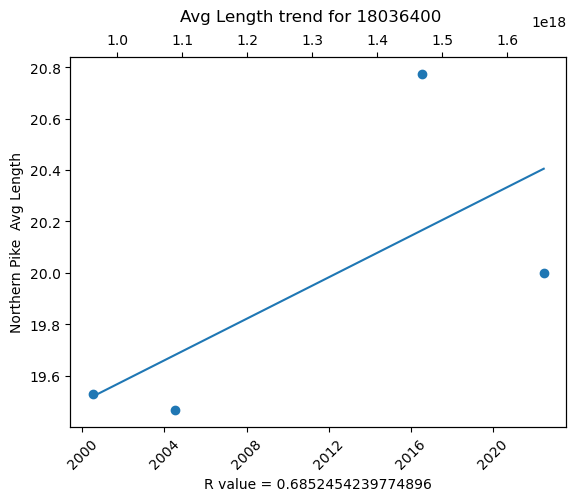

In [178]:
#plot regression lines for each lake average fish length over time
plot_regression_scatter(fishavglength, length_sdate, length_ndate, cpue_results, "Avg Length")

#### End of Report